In [1]:
import numpy as np
import pandas as pd

# Configurar la semilla aleatoria para reproducibilidad
np.random.seed(42)

# Número de registros
n = 10325

# Definir probabilidades para Marital Status
marital_status_probabilities = {
    'Single': 0.4,
    'Married': 0.4,
    'Together': 0.15,
    'Widow': 0.05
}

# Generar Marital Status
marital_status = np.random.choice(list(marital_status_probabilities.keys()), size=n, p=list(marital_status_probabilities.values()))

# Inicializar listas para Kidhome y Teenhome
kidhome = []
teenhome = []

# Calcular Kidhome y Teenhome basado en Marital Status
for status in marital_status:
    if status == 'Widow' or status == 'Single':
        # Viudos con menor probabilidad de tener niños o adolescentes en casa
        kidhome.append(np.random.choice([0, 1], p=[0.9, 0.1]))
        teenhome.append(0)  # Suponiendo que es menos probable que los viudos tengan adolescentes en casa
    else:
        # Otros estados civiles con diferentes distribuciones
        kidhome.append(np.random.choice([0, 1, 2], p=[0.5, 0.3, 0.2]))
        teenhome.append(np.random.choice([0, 1, 2], p=[0.3, 0.3, 0.4]))

# Generar Education Level y calcular Income basado en Education Level y Marital Status
education_levels = ['Basic', '2n Cycle', 'Graduation', 'Master', 'PhD']
education_level = np.random.choice(education_levels, size=n, p=[0.05, 0.1, 0.5, 0.25, 0.1])

# Mapeo de Education Level a Income boost
education_income_boost = {'Basic': 0, '2n Cycle': 8000, 'Graduation': 13000, 'Master': 20000, 'PhD': 30000}
income = np.array([np.random.normal(loc=50000 + education_income_boost[edu], scale=15000) for edu in education_level])

# Mapeo de Marital Status a Income adjustment
marital_income_adjustment = {'Single': 0, 'Together': 3000, 'Married': 10000, 'Widow': 15000}
income += np.array([marital_income_adjustment[status] for status in marital_status])

# Calcular Recency tomando en cuenta Income, Kidhome, Teenhome y Marital Status
recency_factors = income / 10000 + (np.array(kidhome) + np.array(teenhome)) * 5
recency = np.random.normal(loc=50 - recency_factors, scale=15, size=n).clip(min=0, max=99)

# Crear el DataFrame final
df_simulated_revised = pd.DataFrame({
    'Marital_Status': marital_status,
    'Kidhome': kidhome,
    'Teenhome': teenhome,
    'Education_Level': education_level,
    'Income': income,
    'Recency': recency
})

# Ajustar el cálculo de lam para cada categoría de producto para asegurar que siempre sea positivo

# Ejemplo ajustado para MntWines, evitando valores negativos para lam
df_simulated_revised['MntWines'] = np.random.poisson(lam=np.maximum((df_simulated_revised['Income'] / 1000) * (2 - (df_simulated_revised['Kidhome'] + df_simulated_revised['Teenhome'])), 0), size=n)

# Repetir la lógica ajustada para otras categorías, asegurando que lam sea siempre positivo
df_simulated_revised['MntFruits'] = np.random.poisson(lam=np.maximum((df_simulated_revised['Income'] / 5000) * (1 + df_simulated_revised['Kidhome']), 0), size=n)
df_simulated_revised['MntMeatProducts'] = np.random.poisson(lam=np.maximum((df_simulated_revised['Income'] / 2000) * (2 - df_simulated_revised['Kidhome']), 0), size=n)
df_simulated_revised['MntFishProducts'] = np.random.poisson(lam=np.maximum((df_simulated_revised['Income'] / 3000) * (1 + df_simulated_revised['Teenhome']), 0), size=n)
df_simulated_revised['MntSweetProducts'] = np.random.poisson(lam=np.maximum((df_simulated_revised['Income'] / 4000) * (1 + (df_simulated_revised['Kidhome'] + df_simulated_revised['Teenhome'])), 0), size=n)
df_simulated_revised['MntGoldProds'] = np.random.poisson(lam=np.maximum((df_simulated_revised['Income'] / 5000) * (1 - (df_simulated_revised['Kidhome'] + df_simulated_revised['Teenhome']) * 0.5), 0), size=n)
df_simulated_revised['MntTotal'] = df_simulated_revised['MntWines'] + df_simulated_revised['MntFruits'] + df_simulated_revised['MntMeatProducts'] + df_simulated_revised['MntFishProducts'] + df_simulated_revised['MntSweetProducts'] + df_simulated_revised['MntGoldProds']
# Ajustar la lógica para la aceptación de campañas para evitar valores negativos o NaNs
min_probability = 0.0
max_probability = 1.0
df_simulated_revised['AcceptedCmpOverall'] = np.random.binomial(1, 
    p=np.clip((df_simulated_revised['Income'] - 30000) / 100000 + 
              (100 - df_simulated_revised['Recency']) / 200 - 
              (df_simulated_revised['Kidhome'] + df_simulated_revised['Teenhome']) * 0.01, 
              min_probability, max_probability), 
    size=n)

# AcceptedCmp1-5: Probabilidad basada en ingresos y recency
campaign_probs = (df_simulated_revised['Income'] / 100000 + (100 - df_simulated_revised['Recency']) / 200) / 10
for i in range(1, 6):
    df_simulated_revised[f'AcceptedCmp{i}'] = np.random.binomial(1, p=campaign_probs)

# Age: Simular de manera que tenga sentido con el estado civil
# Suponer que los viudos tienden a ser mayores
age = np.random.normal(loc=40, scale=10, size=len(df_simulated_revised))  # Base age
age[df_simulated_revised['Marital_Status'] == 'Widow'] += np.random.normal(loc=10, scale=5, size=(df_simulated_revised['Marital_Status'] == 'Widow').sum())
df_simulated_revised['Age'] = np.round(age).clip(min=18)

# Complain: Baja probabilidad general
df_simulated_revised['Complain'] = np.random.binomial(1, p=0.05, size=len(df_simulated_revised))

# Customer_Days: Días desde que se convirtieron en clientes
df_simulated_revised['Customer_Days'] = np.random.randint(100, 5000, size=len(df_simulated_revised))

# MntTotal ya calculado, ajustar MntRegularProds
df_simulated_revised['MntRegularProds'] = df_simulated_revised['MntTotal'] - df_simulated_revised['MntGoldProds']

# NumCatalogPurchases, NumDealsPurchases, NumStorePurchases, NumWebPurchases: basado en ingresos y edad
df_simulated_revised['NumCatalogPurchases'] = np.random.poisson(lam=df_simulated_revised['Income'] / 20000, size=len(df_simulated_revised))
df_simulated_revised['NumDealsPurchases'] = np.random.poisson(lam=5 - df_simulated_revised['Income'] / 50000, size=len(df_simulated_revised))
df_simulated_revised['NumStorePurchases'] = np.random.poisson(lam=df_simulated_revised['Age'] / 20, size=len(df_simulated_revised))
df_simulated_revised['NumWebPurchases'] = np.random.poisson(lam=df_simulated_revised['Income'] / 25000, size=len(df_simulated_revised))

# NumWebVisitsMonth: Influenciado por la edad y el número de hijos
df_simulated_revised['NumWebVisitsMonth'] = np.random.poisson(lam=5 + df_simulated_revised['Kidhome'] + df_simulated_revised['Teenhome'], size=len(df_simulated_revised)).clip(max=20)

# Response: Última campaña, probabilidad similar a AcceptedCmp1-5
df_simulated_revised['Response'] = np.random.binomial(1, p=campaign_probs)

# Z_CostContact, Z_Revenue: Valores constantes como indicado
df_simulated_revised['Z_CostContact'] = 3
df_simulated_revised['Z_Revenue'] = 11

# Validación de coherencia para una variable, por ejemplo, MntTotal
assert df_simulated_revised['MntTotal'].min() >= 0, "MntTotal contiene valores negativos."

# Mostrar resumen de las nuevas columnas
df_simulated_revised[['AcceptedCmp1', 'AcceptedCmp2', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 
                      'Age', 'Complain', 'Customer_Days', 'MntRegularProds', 'MntTotal', 
                      'NumCatalogPurchases', 'NumDealsPurchases', 'NumStorePurchases', 'NumWebPurchases', 
                      'NumWebVisitsMonth', 'Response', 'Z_CostContact', 'Z_Revenue']].head()


,AcceptedCmp1,AcceptedCmp2,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,Age,Complain,Customer_Days,MntRegularProds,MntTotal,NumCatalogPurchases,NumDealsPurchases,NumStorePurchases,NumWebPurchases,NumWebVisitsMonth,Response,Z_CostContact,Z_Revenue
0,0,1,1,0,0,46.0,0,566,293,304,5,2,3,1,4,1,3,11
1,1,0,0,0,0,39.0,0,3103,369,394,1,7,0,2,2,0,3,11
2,0,0,0,0,0,36.0,0,565,192,194,3,6,0,5,6,0,3,11
3,0,0,0,0,0,35.0,0,1582,171,171,4,1,1,2,4,0,3,11
4,0,0,0,0,0,45.0,0,2250,268,294,1,4,5,6,4,0,3,11


In [2]:
df_simulated_revised['Income'] = df_simulated_revised['Income'].astype(int)
df_simulated_revised['Recency'] = df_simulated_revised['Recency'].astype(int)

In [3]:
df_simulated_revised.to_csv('ifood_simulado.csv', index=False)

# Visualización de datos con Python

Nuevamente cargamos el dataset de ifood para hacer una exploración de los datos. Para este caso, vamos a hacer una exploración de los datos desde las medidas de tendencia central y dispersión. Así mismo, vamos a hacer una exploración de los datos categóricos que aquí se encuentran escritos como variables dummy.

## Carga de datos

Recordemos que para cargar los datos debe hacer clic en el panel izquierdo en el botón de exploración de archivos. En ese menu tendra la opción de subir algunos datos. 

```{note}
Recuerde que para cargar los datos debe hacer clic en el panel izquierdo en el botón de exploración de archivos. En ese menu tendra la opción de subir algunos datos. En Google Colab, el archivo se borrará una vez que se cierre el entorno.
```


In [4]:
import pandas as pd

# Load the dataset from the user's Google Drive
df = pd.read_csv("ifood_simulado.csv")

# Show DataFrame
df.head(5)


,Marital_Status,Kidhome,Teenhome,Education_Level,Income,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,...,Customer_Days,MntRegularProds,NumCatalogPurchases,NumDealsPurchases,NumStorePurchases,NumWebPurchases,NumWebVisitsMonth,Response,Z_CostContact,Z_Revenue
0,Single,0,0,Master,74927,39,156,17,82,18,...,566,293,5,2,3,1,4,1,3,11
1,Widow,0,0,Master,95766,22,192,17,101,28,...,3103,369,1,7,0,2,2,0,3,11
2,Married,0,1,Graduation,59676,46,50,7,57,46,...,565,192,3,6,0,5,6,0,3,11
3,Married,2,2,Graduation,59663,2,0,39,0,62,...,1582,171,4,1,1,2,4,0,3,11
4,Single,0,0,Graduation,66230,42,152,15,69,20,...,2250,268,1,4,5,6,4,0,3,11


## Visualización de datos

La visualización de datos es una parte fundamental en el análisis de datos. Los gráficos nos permiten comprender y comunicar de manera efectiva la información contenida en los datos.

En este notebook, utilizaremos las siguientes bibliotecas para crear gráficos:

- Matplotlib: una biblioteca de trazado de gráficos en 2D que produce figuras de calidad de publicación en una variedad de formatos impresos y entornos interactivos en todas las plataformas.
- Seaborn: una biblioteca de visualización de datos basada en Matplotlib que proporciona una interfaz de alto nivel para dibujar gráficos estadísticos atractivos y informativos.
- Plotly: una biblioteca de visualización interactiva que permite crear gráficos interactivos y personalizables.

```{note}
Las librerias son modulos de python que contienen funciones y objetos que pueden ser utilizados para realizar tareas específicas. En este caso, las librerias matplotlib, seaborn y plotly son librerias de visualización de datos. Recuerda que ya hemos cargado pandas y numpy. Cada vez que se inicializa el entorno de ejecución, es necesario volver a cargar las librerias y deben incluirse todas las librerias que se van a utilizar en el notebook.
```


### Gráficos de datos numéricos

Vamos a hacer una exploración de los datos numéricos que se encuentran en el dataset. Para ello, vamos a hacer un análisis de las medidas de tendencia central y dispersión. Así mismo, vamos a hacer un análisis de la distribución de los datos. 

```{note}
Recuerda que los datos numéricos son aquellos que se pueden sumar, restar, multiplicar o dividir. En este caso, vamos a hacer un análisis de las variables numéricas que se encuentran en el dataset.
```

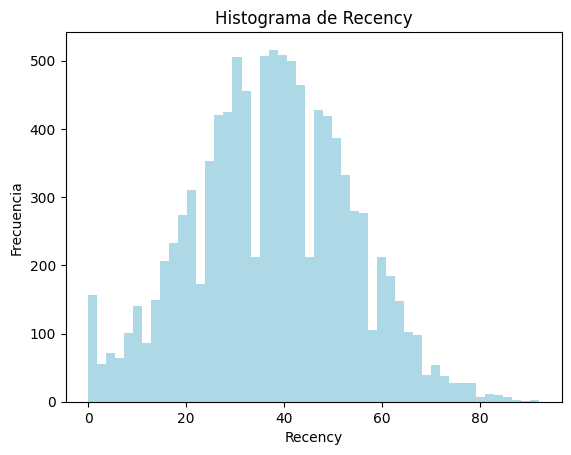

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

## Gráficos para la variable 'Recency'

# Histograma

plt.hist(df['Recency'], bins=50, color='lightblue')
plt.xlabel('Recency')
plt.ylabel('Frecuencia')
plt.title('Histograma de Recency')
plt.show()

```{note}
El comando bins es utilizado para definir el número de intervalos en los que se va a dividir el histograma. 
```
```{admonition} Ejercicio

Realiza un análisis de las variables numéricas que se encuentran en el dataset. ¿Como se interpreta el gráfico si se modifica varias veces el comando `bins`?
```


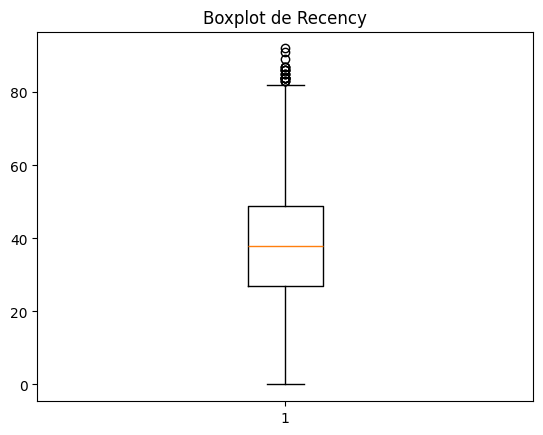

In [6]:
### Boxplot

plt.boxplot(df['Recency'])
plt.title('Boxplot de Recency')
plt.show()

```{admonition} Ejercicio

¿Cómo se interpreta el gráfico boxplot? ¿Qué información nos da este gráfico?
```

### Gráficos para dos variables

En el caso de las variables que tenemos en el dataset, resultaría interesante ver la relación entre 'Recency' y 'Income'. Para ello, vamos a hacer un gráfico de dispersión. 

```{note}
El gráfico de dispersión es un gráfico que utiliza coordenadas cartesianas para mostrar los valores de dos variables para un conjunto de datos. Los datos se muestran como una colección de puntos, cada uno con el valor de una variable que determina la posición en el eje horizontal y el valor de la otra variable que determina la posición en el eje vertical.
```

```{admonition} Ejercicio

Realiza un gráfico de dispersión entre las variables 'Recency' e 'Income'. ¿Qué relación observas entre estas dos variables?
```

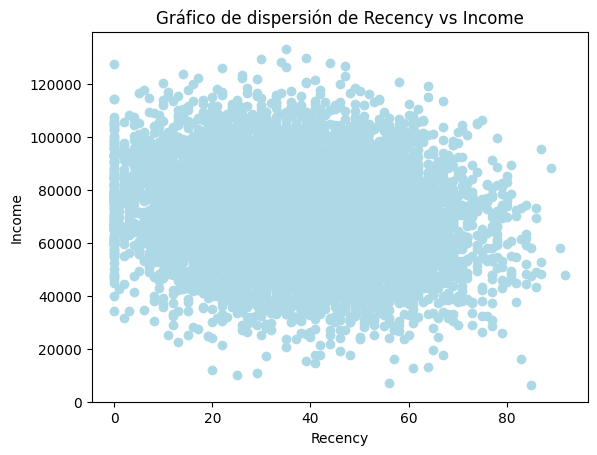

In [7]:
### Gráfico de dispersión

plt.scatter(df['Recency'], df['Income'], color='lightblue')
plt.xlabel('Recency')
plt.ylabel('Income')
plt.title('Gráfico de dispersión de Recency vs Income')
plt.show()

### Gráficos para variables categóricas

En este dataset no hay variables categoricas, pero vamos a hacer un análisis de las variables dummy que se encuentran en el dataset. 

```{note}
Las variables dummy son variables que toman el valor de 0 o 1 para indicar la presencia o ausencia de una categoría. 
```

```{admonition} Ejercicio
¿Cuáles son las variables dummy que se encuentran en el dataset? Realiza un análisis de estas variables. 
```

In [8]:
df.columns

Index(['Marital_Status', 'Kidhome', 'Teenhome', 'Education_Level', 'Income',
       'Recency', 'MntWines', 'MntFruits', 'MntMeatProducts',
       'MntFishProducts', 'MntSweetProducts', 'MntGoldProds', 'MntTotal',
       'AcceptedCmpOverall', 'AcceptedCmp1', 'AcceptedCmp2', 'AcceptedCmp3',
       'AcceptedCmp4', 'AcceptedCmp5', 'Age', 'Complain', 'Customer_Days',
       'MntRegularProds', 'NumCatalogPurchases', 'NumDealsPurchases',
       'NumStorePurchases', 'NumWebPurchases', 'NumWebVisitsMonth', 'Response',
       'Z_CostContact', 'Z_Revenue'],
      dtype='object')

En este caso las variables dummy son `'marital_Divorced', 'marital_Married','marital_Single', 'marital_Together', 'marital_Widow'`, el siguiente código permitira convertirla en una sola variable. 

In [9]:
#df['marital'] = df[['marital_Divorced', 'marital_Married','marital_Single', 'marital_Together', 'marital_Widow']].idxmax(axis=1)

In [10]:
df.Marital_Status

0         Single
1          Widow
2        Married
3        Married
4         Single
          ...   
10320    Married
10321     Single
10322      Widow
10323     Single
10324     Single
Name: Marital_Status, Length: 10325, dtype: object

```{note}
La función idxmax() devuelve el índice de la primera aparición del valor máximo.
```

```{admonition} Ejercicio
¿Cómo comprobarías que los datos están bien definidos, esto es,  que no se repiten valores en las variables dummy?
```

Quitamos de la variable df['marital'] el prefijo 'marital_' y lo guardamos en la variable df['marital'].

```{note}
la función `.str` permite acceder a los métodos de las cadenas de texto y transforma cada elemento de la serie como cadena de texto.

En este caso `.replace` reemplaza el prefijo 'marital_' por un espacio vacío.
```

```{admonition} Ejercicio

Realiza transformaciones a las cadenas de texto con las siguientes funciones: `.lower()`, `.upper()`, `.capitalize()`, `.title()`. ¿Qué hace cada una de estas funciones?

`df['marital'] = df['marital'].str.lower()`
```


Ya que tenemos una variable categórica, vamos a hacer un análisis de la distribución de los datos. 


In [11]:
### Tabla de frecuencias

df['Marital_Status'].value_counts()

Marital_Status
Single      4192
Married     4107
Together    1535
Widow        491
Name: count, dtype: int64

<Axes: xlabel='Marital_Status'>

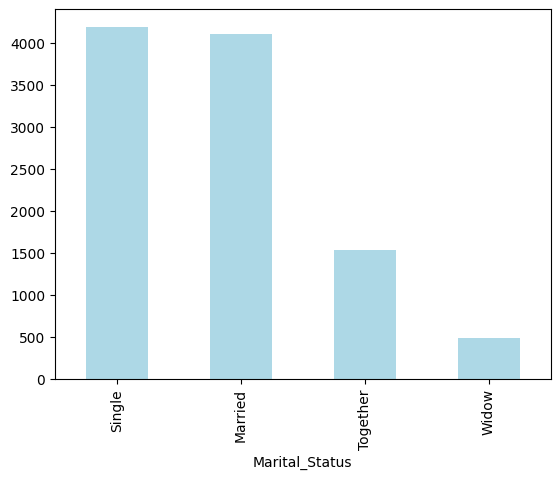

In [12]:
### Gráfico de barras

df['Marital_Status'].value_counts().plot(kind='bar', color='lightblue')

C:\Users\cizai\AppData\Local\Temp\ipykernel_3144\530408223.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Marital_Status', data=df, palette='Blues')


<Axes: xlabel='Marital_Status', ylabel='count'>

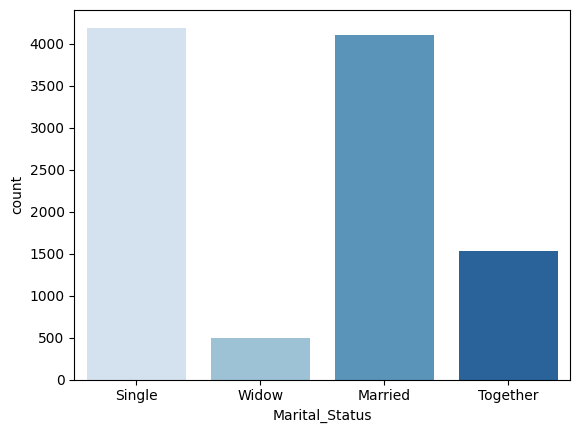

In [13]:
### Otra forma de hacerlo

sns.countplot(x='Marital_Status', data=df, palette='Blues')

<Axes: ylabel='count'>

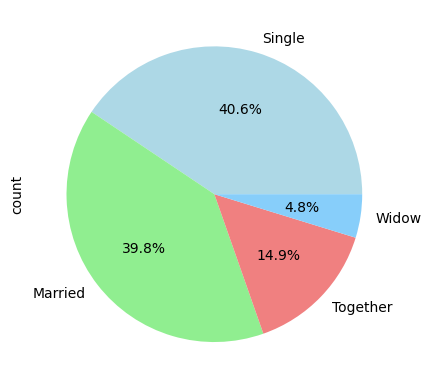

In [14]:
### Gráfico de pastel

df['Marital_Status'].value_counts().plot(kind='pie', autopct='%1.1f%%', colors=['lightblue', 'lightgreen', 'lightcoral', 'lightskyblue', 'lightpink'])

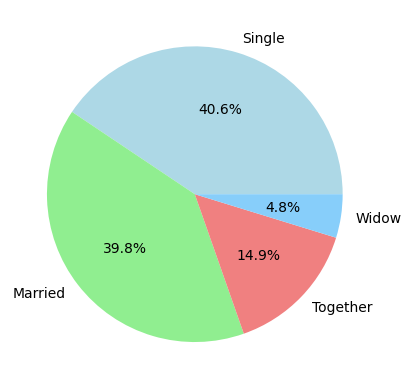

In [15]:
### Otra forma de hacerlo

plt.pie(df['Marital_Status'].value_counts(), 
        labels=df['Marital_Status'].value_counts().index, 
        autopct='%1.1f%%', 
        colors=['lightblue', 'lightgreen', 'lightcoral', 'lightskyblue', 'lightpink'])
plt.show()

<Axes: xlabel='Teenhome', ylabel='Income'>

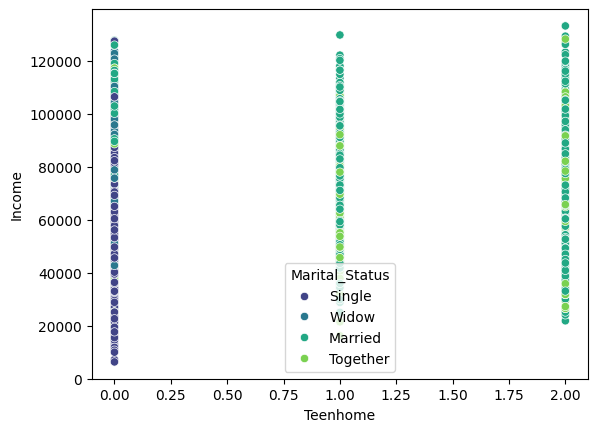

In [16]:
### Scatterplot para tres variables

sns.scatterplot(x='Teenhome', y='Income', hue='Marital_Status', data=df, palette='viridis')

C:\Users\cizai\AppData\Local\Temp\ipykernel_3144\1106627374.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Marital_Status', y='Age', data=df, palette='viridis')


<Axes: xlabel='Marital_Status', ylabel='Age'>

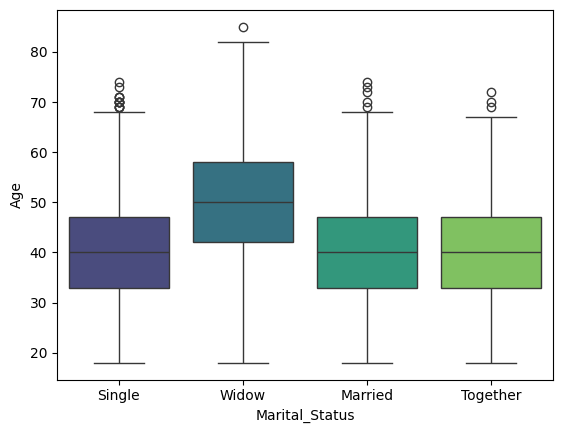

In [17]:
### Boxplot 

sns.boxplot(x='Marital_Status', y='Age', data=df, palette='viridis')

In [18]:
!pip install ucimlrepo

In [19]:
from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
bank_marketing = fetch_ucirepo(id=222) 
  
# data (as pandas dataframes) 
X = bank_marketing.data.features 
y = bank_marketing.data.targets 


In [20]:
### Revisemos los dato nulos

X.isnull().sum()

age                0
job              288
marital            0
education       1857
default            0
balance            0
housing            0
loan               0
contact        13020
day_of_week        0
month              0
duration           0
campaign           0
pdays              0
previous           0
poutcome       36959
dtype: int64

In [21]:
## Dataset total

DF=X
DF['HasTermDeposit'] = y

In [22]:
DF.to_csv('bank_marketing.csv', index=False)

In [23]:
bank_marketing.variables

,name,role,type,demographic,description,units,missing_values
0,age,Feature,Integer,Age,None,None,no
1,job,Feature,Categorical,Occupation,"type of job (categorical: 'admin.','blue-colla...",None,no
2,marital,Feature,Categorical,Marital Status,"marital status (categorical: 'divorced','marri...",None,no
3,education,Feature,Categorical,Education Level,"(categorical: 'basic.4y','basic.6y','basic.9y'...",None,no
4,default,Feature,Binary,None,has credit in default?,None,no
5,balance,Feature,Integer,None,average yearly balance,euros,no
6,housing,Feature,Binary,None,has housing loan?,None,no
7,loan,Feature,Binary,None,has personal loan?,None,no
8,contact,Feature,Categorical,None,contact communication type (categorical: 'cell...,None,yes
9,day_of_week,Feature,Date,None,last contact day of the week,None,no
